In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import requests
import io
import time
import copy
import random
import os
from tqdm import tqdm
from torch.optim import lr_scheduler

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed impostato a {seed} per riproducibilità.")

set_seed(42)

Seed impostato a 42 per riproducibilità.


In [29]:
class QuantumCircuit:
    def __init__(self, n_qubits, n_layers, ansatz_type='basic', reuploading=False):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.ansatz_type = ansatz_type
        self.reuploading = reuploading
        
        try:
            self.dev = qml.device('lightning.qubit', wires=n_qubits)
        except:
            self.dev = qml.device('default.qubit', wires=n_qubits)
            
        @qml.qnode(self.dev, interface='torch')
        def circuit(inputs, weights):
            # Encoding iniziale (se non re-uploading)
            if not self.reuploading:
                for i in range(self.n_qubits):
                    qml.RX(inputs[i], wires=i)
            
            for layer in range(self.n_layers):
                # Data Re-uploading
                if self.reuploading:
                    for i in range(self.n_qubits):
                        qml.RX(inputs[i], wires=i)
                
                # --- SCELTA ANSATZ ---
                if self.ansatz_type == 'basic':
                    # 1 Parametro per qubit (Rx) -> Veloce, poco espressivo
                    for i in range(self.n_qubits):
                        qml.RX(weights[layer, i], wires=i)
                    # Entanglement
                    for i in range(self.n_qubits - 1): qml.CNOT(wires=[i, i + 1])
                    if self.n_qubits > 1: qml.CNOT(wires=[self.n_qubits - 1, 0])
                        
                elif self.ansatz_type == 'strong':
                    # 3 Parametri per qubit (U3) -> Lento, massima potenza
                    w_layer = weights[layer].unsqueeze(0) 
                    qml.StronglyEntanglingLayers(w_layer, wires=range(self.n_qubits))
                
                elif self.ansatz_type == 'efficient':
                    # --- LA VIA DI MEZZO (EfficientSU2 style) ---
                    # 2 Parametri per qubit (Ry, Rz) -> Bilanciato
                    # Pesi shape: (n_layers, n_qubits, 2)
                    for i in range(self.n_qubits):
                        qml.RY(weights[layer, i, 0], wires=i) # Latitudine
                        qml.RZ(weights[layer, i, 1], wires=i) # Longitudine
                    
                    # Entanglement (Chain)
                    for i in range(self.n_qubits - 1): qml.CNOT(wires=[i, i + 1])
                    if self.n_qubits > 1: qml.CNOT(wires=[self.n_qubits - 1, 0])
            
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        
        self.circuit = circuit
    
    def forward(self, inputs, weights):
        batch_size = inputs.shape[0]
        results = []
        for i in range(batch_size):
            res = self.circuit(inputs[i], weights)
            if isinstance(res, list): res = torch.stack(res)
            results.append(res)
        return torch.stack(results).float()

# ==================== 2. LAYER IBRIDO AGGIORNATO ====================
class VQCLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits, n_layers, 
                 use_scale_factor=False, ansatz_type='basic', reuploading=False):
        super(VQCLayer, self).__init__()
        self.n_qubits = n_qubits
        self.use_scale_factor = use_scale_factor
        
        self.fc_in = nn.Linear(input_dim, n_qubits)
        self.qc = QuantumCircuit(n_qubits, n_layers, ansatz_type, reuploading)
        
        # --- GESTIONE DIMENSIONI PESI ---
        if ansatz_type == 'strong':
            # 3 params (Rot X, Y, Z)
            self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits, 3) * 0.1)
        elif ansatz_type == 'efficient':
            # 2 params (Rot Y, Z) -> LA VIA DI MEZZO
            self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits, 2) * 0.1)
        else:
            # 1 param (Rot X)
            self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits) * 0.1)
            
        self.fc_out = nn.Linear(n_qubits, hidden_dim)

        if self.use_scale_factor:
            self.scale_factor = nn.Parameter(torch.ones(n_qubits))

    def forward(self, x):
        x = self.fc_in(x)
        if self.use_scale_factor:
            x = torch.tanh(x) * self.scale_factor 
        x = self.qc.forward(x, self.q_params)
        x = self.fc_out(x)
        return x


class QGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits, n_layers, 
                 use_scale_factor, ansatz_type, reuploading):
        super(QGRUCell, self).__init__()
        self.hidden_dim = hidden_dim
        concat_dim = hidden_dim + input_dim
        
        # Configurazione condivisa per i 3 gate
        config = {
            'input_dim': concat_dim, 'hidden_dim': hidden_dim,
            'n_qubits': n_qubits, 'n_layers': n_layers,
            'use_scale_factor': use_scale_factor,
            'ansatz_type': ansatz_type, 'reuploading': reuploading
        }
        
        self.vqc_reset = VQCLayer(**config)
        self.vqc_update = VQCLayer(**config)
        self.vqc_output = VQCLayer(**config)
    
    def forward(self, x, h_prev):
        combined = torch.cat([h_prev, x], dim=1)
        
        r_t = torch.sigmoid(self.vqc_reset(combined))
        z_t = torch.sigmoid(self.vqc_update(combined))
        
        combined_reset = torch.cat([r_t * h_prev, x], dim=1)
        h_tilde = torch.tanh(self.vqc_output(combined_reset))
        
        h = z_t * h_prev + (1 - z_t) * h_tilde
        return h
class QGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers, 
                 use_scale_factor=False, ansatz_type='basic', reuploading=False):
        super(QGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.qgru_cell = QGRUCell(input_dim, hidden_dim, n_qubits, n_layers, 
                                  use_scale_factor, ansatz_type, reuploading)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h_0=None):
        batch_size, seq_len, _ = x.shape
        if h_0 is None:
            h = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        else:
            h = h_0
        
        outputs = []
        for t in range(seq_len):
            h = self.qgru_cell(x[:, t, :], h)
            out = self.fc_out(h)
            outputs.append(out)
        
        outputs = torch.stack(outputs, dim=1)
        return outputs, h
    


class ClassicalGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassicalGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, h = self.gru(x)
        out = self.fc_out(out)
        return out, h


In [30]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = torch.FloatTensor(data)
        self.window_size = window_size
    def __len__(self): return len(self.data) - self.window_size
    def __getitem__(self, idx):
        return self.data[idx:idx+self.window_size, :-1], self.data[idx+1:idx+self.window_size+1, -1:]

In [31]:
def load_data():
    try:
        url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
        print("Scaricamento dataset ETTh1...")
        df = pd.read_csv(io.StringIO(requests.get(url, timeout=10).content.decode('utf-8')))
        return df[['HUFL', 'HULL', 'MUFL', 'OT']].values
    except:
        print("Fallback su dati sintetici...")
        t = np.linspace(0, 100, 2000)
        return np.column_stack([np.sin(t), np.cos(t), np.sin(t)*np.cos(t), np.sin(t+0.5)])

def evaluate_final(model, loader, device):
    model.eval()
    mse_loss, mae_loss = 0, 0
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            mse_loss += criterion_mse(out, y).item()
            mae_loss += criterion_mae(out, y).item()
    return mse_loss / len(loader), mae_loss / len(loader)

def train_experiment(model, train_loader, val_loader, epochs, lr, device, name):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # Scheduler come da paper (opzionale se poche epoche, ma corretto averlo)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f"\n--- Training {name} ---")
    start_total = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Ep {epoch+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out, _ = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        scheduler.step()
        avg_train = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                out, _ = model(x.to(device))
                val_loss += criterion(out, y.to(device)).item()
        avg_val = val_loss / len(val_loader)
        
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)
        
        print(f"Ep {epoch+1} | Train: {avg_train:.5f} | Val: {avg_val:.5f}")
        
        # Save best model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"Best Val Loss: {best_val_loss:.5f}")
    
    total_time = time.time()-start_total
    print(f"Total Time {name}: {total_time:.1f}s")
    return history, total_time

def get_model_summary(model, name):
    print(f"\n{'='*10} {name} SUMMARY {'='*10}")
    # print(model) # Rimosso per pulizia output
    total_params = sum(p.numel() for p in model.parameters())
    
    # Conta parametri quantistici (quelli chiamati 'q_params')
    q_params = 0
    for n, p in model.named_parameters():
        if 'q_params' in n:
            q_params += p.numel()
    
    c_params = total_params - q_params
    
    print(f"Total Parameters: {total_params}")
    print(f"  - Classical: {c_params}")
    print(f"  - Quantum:   {q_params}")
    print(f"{'='*30}")

def draw_model_circuit(model):
    # Verifica se è un modello QGRU controllando se ha l'attributo 'qgru_cell'
    if not hasattr(model, 'qgru_cell'):
        return

    # Visualizziamo i circuiti per i tre componenti principali: Reset, Update, e Candidate (Cell State)
    components = [
        ("Reset Gate", model.qgru_cell.vqc_reset),
        ("Update Gate", model.qgru_cell.vqc_update),
        ("Cell State (Candidate)", model.qgru_cell.vqc_output)
    ]

    for name, vqc in components:
        try:
            qc_instance = vqc.qc
            
            # Creiamo input dummy
            n_qubits = qc_instance.n_qubits
            dummy_inputs = torch.rand(n_qubits)
            
            # Creiamo pesi dummy
            dummy_weights = vqc.q_params.detach().clone().cpu()
            
            # Disegno grafico (Matplotlib)
            try:
                # qml.draw_mpl restituisce (fig, ax)
                fig, ax = qml.draw_mpl(qc_instance.circuit)(dummy_inputs, dummy_weights)
                plt.title(f"{name}")
                plt.show()
            except Exception as e:
                # Se draw_mpl fallisce (es. manca style), proseguiamo col testo
                pass

        except Exception as e:
            print(f"Impossibile disegnare il circuito per {name}: {e}")

Device: cpu
Scaricamento dataset ETTh1...
Dati: Train=12189, Val=2608, Test=2608

[1/3] Avvio My QGRU (EfficentEntangling + Re-uploading)...

========== My QGRU SUMMARY ==========
Total Parameters: 336
  - Classical: 246
  - Quantum:   90


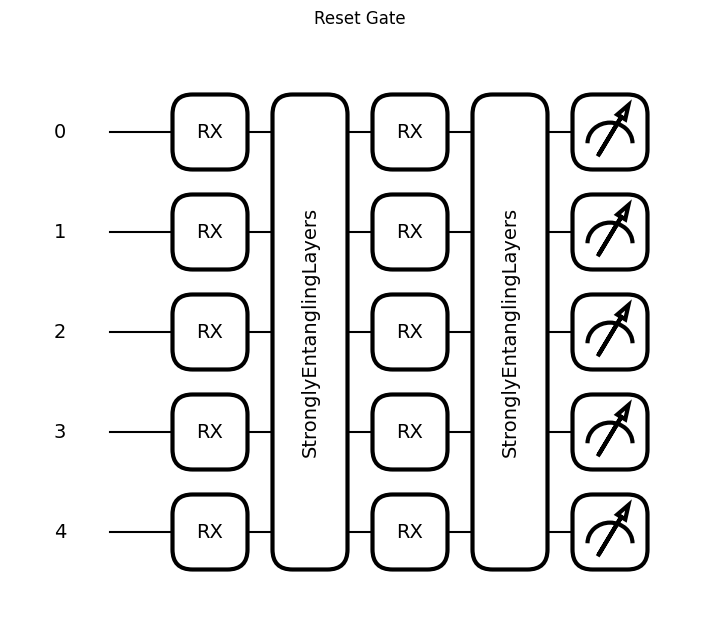

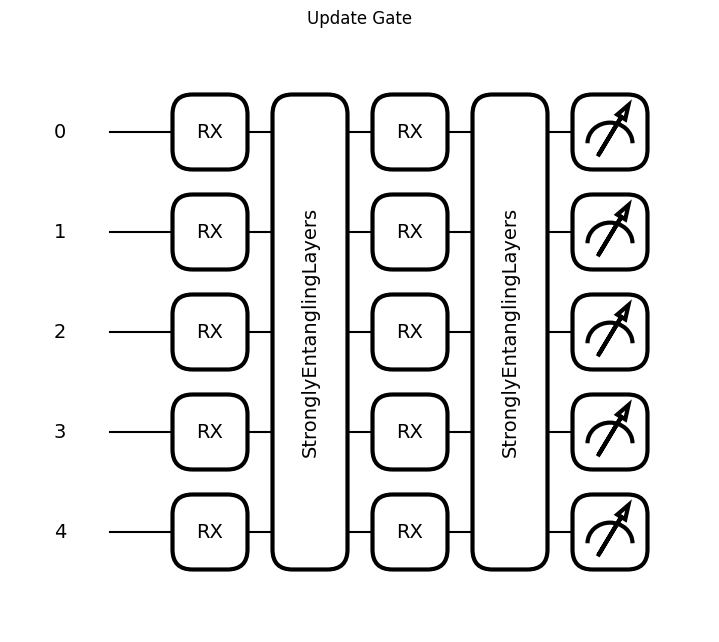

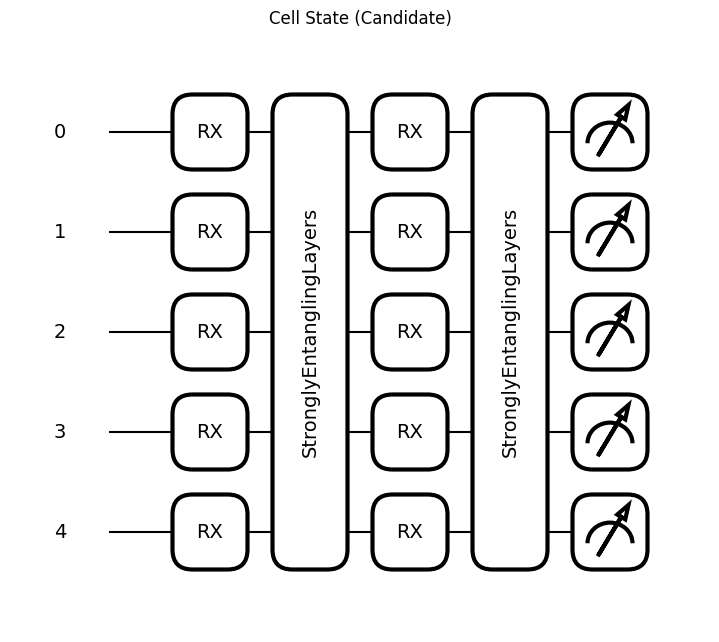


--- Training MY QGRU ---


Ep 1 | Train: 0.09424 | Val: 0.38202


Ep 2 | Train: 0.08164 | Val: 0.30456


Ep 3 | Train: 0.08059 | Val: 0.31687


Ep 4 | Train: 0.07969 | Val: 0.35418


Ep 5 | Train: 0.07915 | Val: 0.33473


Ep 6 | Train: 0.07799 | Val: 0.36962


Ep 7 | Train: 0.07774 | Val: 0.39813


Ep 8 | Train: 0.07744 | Val: 0.34486


Ep 9 | Train: 0.07673 | Val: 0.45472


Ep 10 | Train: 0.07608 | Val: 0.35750
Best Val Loss: 0.30456
Total Time MY QGRU: 20431.7s

[2/3] Avvio Paper QGRU (BasicEntangler Standard)...

========== Paper QGRU SUMMARY ==========
Total Parameters: 261
  - Classical: 231
  - Quantum:   30


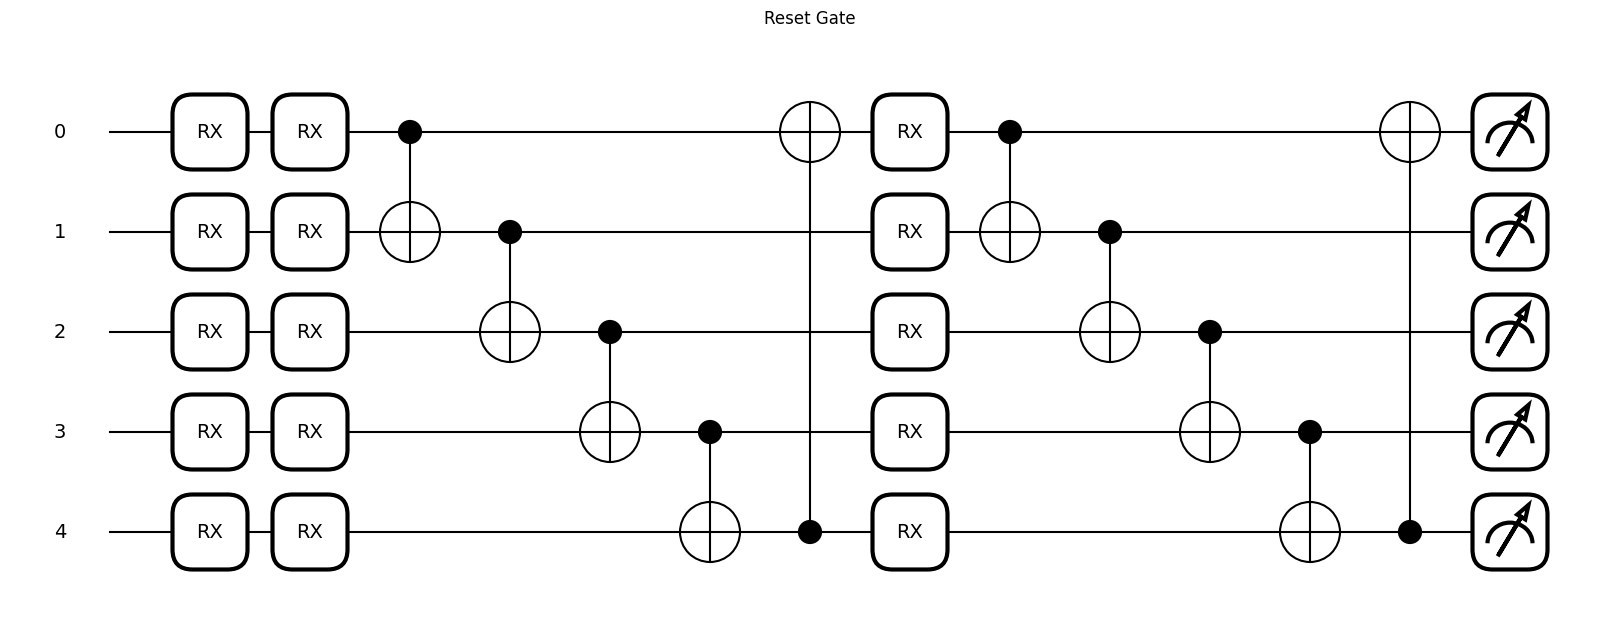

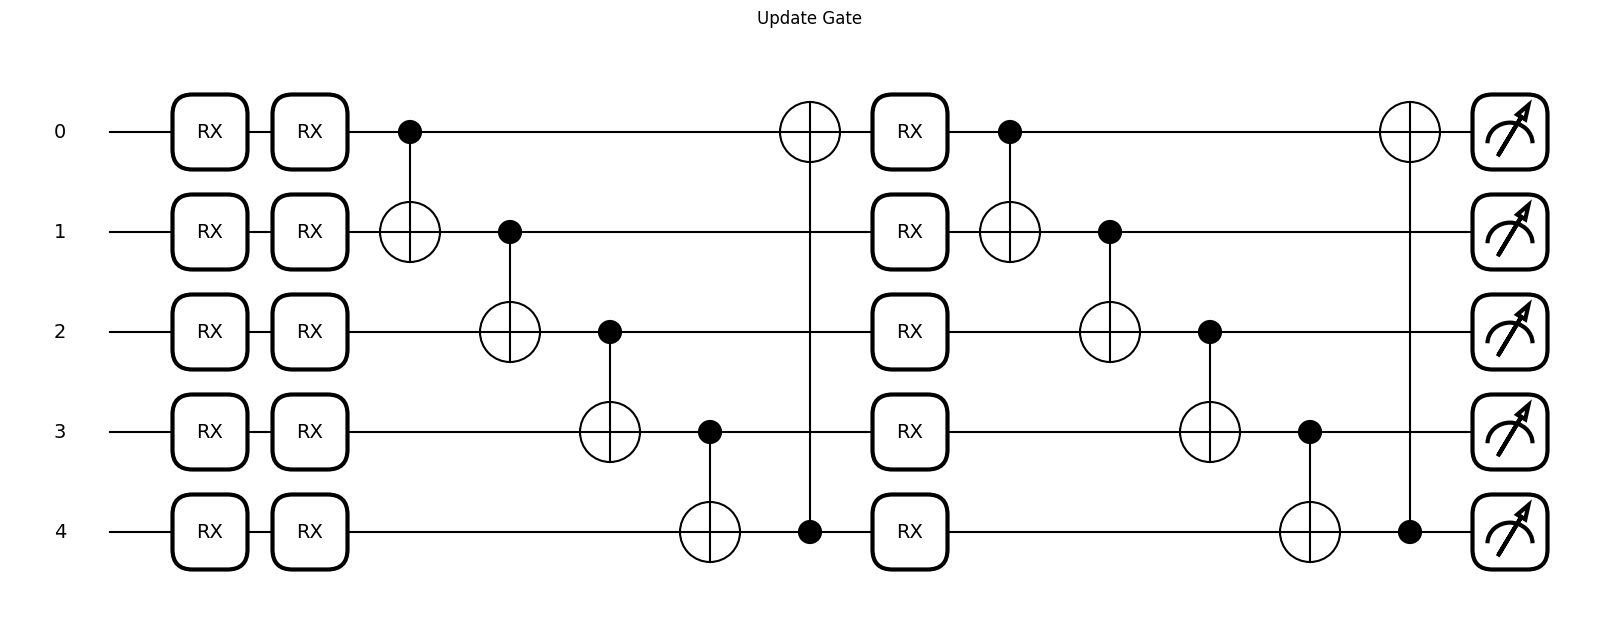

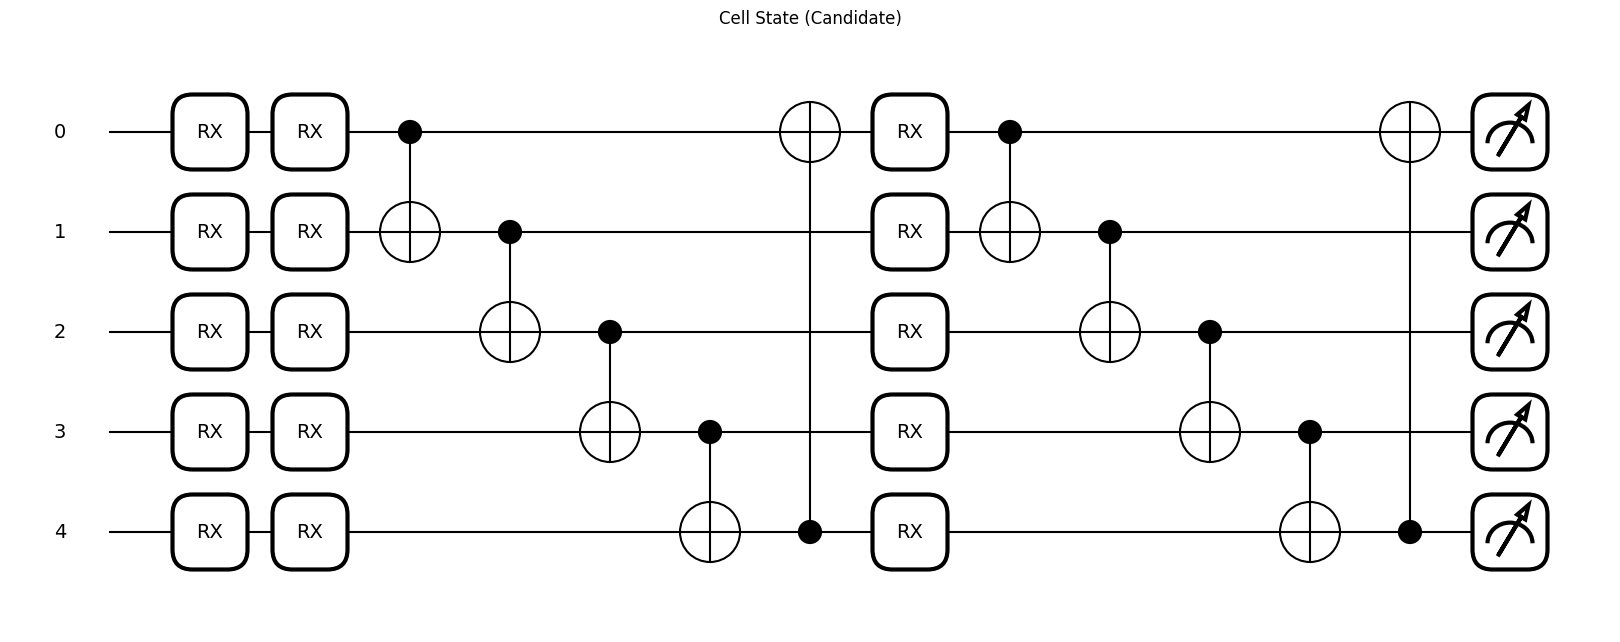


--- Training PAPER QGRU ---


Ep 1 | Train: 0.09519 | Val: 0.29714


Ep 2 | Train: 0.08190 | Val: 0.39411


Ep 3 | Train: 0.08102 | Val: 0.39406


Ep 4 | Train: 0.08011 | Val: 0.31453


Ep 5 | Train: 0.07965 | Val: 0.36436


Ep 6 | Train: 0.07862 | Val: 0.32773


Ep 7 | Train: 0.07839 | Val: 0.32366


Ep 8 | Train: 0.07754 | Val: 0.40607


Ep 9 | Train: 0.07687 | Val: 0.37912


Ep 10 | Train: 0.07613 | Val: 0.46594
Best Val Loss: 0.29714
Total Time PAPER QGRU: 9041.4s

[3/3] Avvio Classical GRU...

========== Classical GRU SUMMARY ==========
Total Parameters: 156
  - Classical: 156
  - Quantum:   0

--- Training CLASSICAL GRU ---


Ep 1 | Train: 0.08638 | Val: 0.33440


Ep 2 | Train: 0.08173 | Val: 0.36068


Ep 3 | Train: 0.08015 | Val: 0.37168


Ep 4 | Train: 0.07932 | Val: 0.34460


Ep 5 | Train: 0.07820 | Val: 0.39842


Ep 6 | Train: 0.07766 | Val: 0.40496


Ep 7 | Train: 0.07723 | Val: 0.37893


Ep 8 | Train: 0.07713 | Val: 0.38874


Ep 9 | Train: 0.07700 | Val: 0.35053


Ep 10 | Train: 0.07679 | Val: 0.34878
Best Val Loss: 0.33440
Total Time CLASSICAL GRU: 7.7s

✅ Risultati salvati in 'risultati_finali_reupload.csv'
                 Model  Test MSE  Test MAE      Time (s)
0  My QGRU (Optimized)  0.156304  0.356961  20431.650260
1           Paper QGRU  0.152318  0.342315   9041.439373
2        Classical GRU  0.173883  0.376851      7.704010


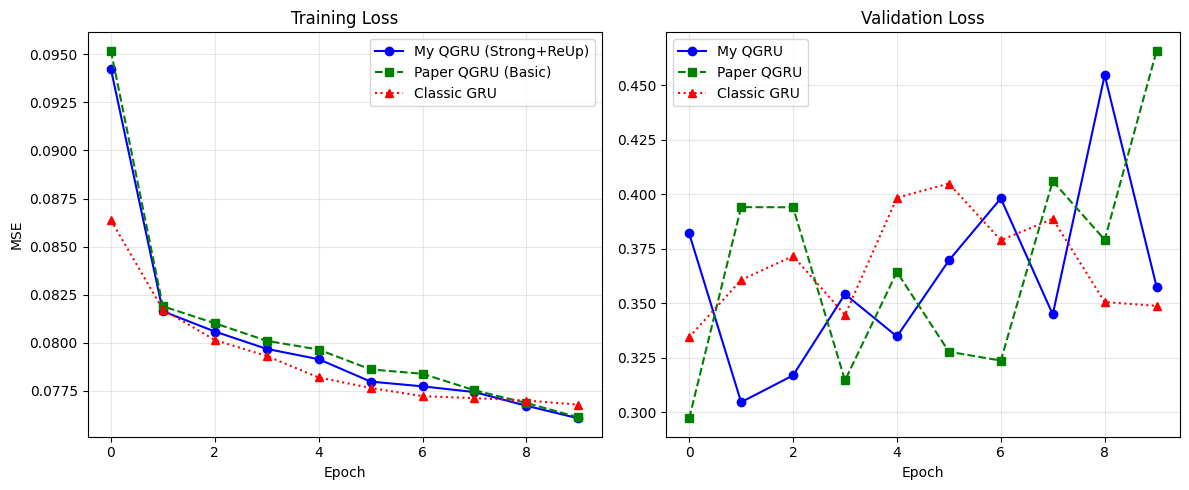

In [ ]:
def main():
    device = torch.device("cpu") # CPU consigliata per simulazioni piccoli circuiti
    print(f"Device: {device}")
    
    # --- IPERPARAMETRI (Specifiche Paper) ---
    WINDOW_SIZE = 5
    HIDDEN_DIM = 5  
    N_QUBITS = 5    
    N_LAYERS = 2    
    BATCH_SIZE = 64
    EPOCHS = 15      # Aumentato da 10 a 30 per migliore convergenza
    LR = 0.005

    # Dati
    raw = load_data()
    
    # Split 70% Train, 15% Val, 15% Test
    n = len(raw)
    train_split = int(n * 0.70)
    val_split = int(n * 0.85)
    
    # Fit scaler solo sul training set per evitare data leakage
    scaler = MinMaxScaler((-1, 1)).fit(raw[:train_split])
    data_scaled = scaler.transform(raw)
    
    train_ds = TimeSeriesDataset(data_scaled[:train_split], WINDOW_SIZE)
    val_ds = TimeSeriesDataset(data_scaled[train_split:val_split], WINDOW_SIZE)
    test_ds = TimeSeriesDataset(data_scaled[val_split:], WINDOW_SIZE)
    
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
    
    print(f"Dati: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")
    
    dims = (raw.shape[1]-1, HIDDEN_DIM, 1) # (Input, Hidden, Output)
    results_list = []

    # --- 1. MY QGRU (Potenziata: Efficient Ent. + Re-upload + Scaling) ---
    print(f"\n[1/3] Avvio My QGRU (EfficentEntangling + Re-uploading)...")
    my_qgru = QGRU(*dims, N_QUBITS, N_LAYERS, 
                   use_scale_factor=True, 
                   ansatz_type='efficient', # Cambiato da 'strong' a 'efficient' per bilanciare velocità/espressività
                   reuploading=True)
    
    get_model_summary(my_qgru, "My QGRU")
    draw_model_circuit(my_qgru)
    
    # Training usa Train e Validation
    hist_my, time_my = train_experiment(my_qgru, train_dl, val_dl, EPOCHS, LR, device, "MY QGRU")
    # Valutazione finale usa Test
    mse_my, mae_my = evaluate_final(my_qgru, test_dl, device)
    
    results_list.append({
        "Model": "My QGRU (Optimized)",
        "Test MSE": mse_my, "Test MAE": mae_my, "Time (s)": time_my
    })

    # --- 2. PAPER QGRU (Basic Ent. + No Re-upload + No Scaling) ---
    print("\n[2/3] Avvio Paper QGRU (BasicEntangler Standard)...")
    paper_qgru = QGRU(*dims, N_QUBITS, N_LAYERS, 
                      use_scale_factor=False, 
                      ansatz_type='basic', 
                      reuploading=False)
    
    get_model_summary(paper_qgru, "Paper QGRU")
    draw_model_circuit(paper_qgru)
    
    hist_paper, time_paper = train_experiment(paper_qgru, train_dl, val_dl, EPOCHS, LR, device, "PAPER QGRU")
    mse_paper, mae_paper = evaluate_final(paper_qgru, test_dl, device)
    
    results_list.append({
        "Model": "Paper QGRU",
        "Test MSE": mse_paper, "Test MAE": mae_paper, "Time (s)": time_paper
    })
    
    # --- 3. CLASSICAL GRU ---
    print("\n[3/3] Avvio Classical GRU...")
    classic_gru = ClassicalGRU(*dims)
    
    get_model_summary(classic_gru, "Classical GRU")
    
    hist_classic, time_classic = train_experiment(classic_gru, train_dl, val_dl, EPOCHS, LR, device, "CLASSICAL GRU")
    mse_classic, mae_classic = evaluate_final(classic_gru, test_dl, device)
    
    results_list.append({
        "Model": "Classical GRU",
        "Test MSE": mse_classic, "Test MAE": mae_classic, "Time (s)": time_classic
    })
    
    # --- SALVATAGGIO CSV ---
    df_results = pd.DataFrame(results_list)
    df_results.to_csv("risultati_finali_reupload.csv", index=False)
    print("\n✅ Risultati salvati in 'risultati_finali_reupload.csv'")
    print(df_results)
    
    # --- PLOT ---
    plt.figure(figsize=(12, 5))
    
    # Train Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist_paper['train_loss'], label='Paper QGRU (Basic)', marker='s', linestyle='--', color='green')
    plt.plot(hist_classic['train_loss'], label='Classic GRU', marker='^', linestyle=':', color='red')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Val Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist_my['val_loss'], label='My QGRU', marker='o', color='blue')
    plt.plot(hist_paper['val_loss'], label='Paper QGRU', marker='s', linestyle='--', color='green')
    plt.plot(hist_classic['val_loss'], label='Classic GRU', marker='^', linestyle=':', color='red')
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comparison_reupload.png')

if __name__ == "__main__":
    main()